In [1]:
# Recomendación de instalación (no ejecuta pip automáticamente).
# Si no tienes dependencias, ejecuta en PowerShell: pip install -r requirements.txt
import importlib
missing = []
for pkg in ('gymnasium','ale_py','shimmy','torch','torchvision','opencv_python','matplotlib','numpy'):
    try:
        importlib.import_module(pkg)
    except Exception:
        missing.append(pkg)
if missing:
    print('Paquetes faltantes:', missing)
    print('Instálalos con: pip install -r requirements.txt')
else:
    print('Dependencias instaladas (aparentemente).')


import torch
import numpy as np

# Permitir numpy scalars globalmente (solo si confías en tus checkpoints)
torch.serialization.add_safe_globals([np._core.multiarray.scalar])

Paquetes faltantes: ['opencv_python']
Instálalos con: pip install -r requirements.txt


In [2]:
# Imports y configuración de ruta
import os
import sys
from pathlib import Path
# Asegurar que el proyecto raíz está en sys.path
proj_root = Path.cwd()
if str(proj_root) not in sys.path:
    sys.path.insert(0, str(proj_root))

from src.train import train_agent
from src.record import record_episode
from src.agent import DQNAgent
import matplotlib.pyplot as plt
from IPython.display import Video, display

print('Project root:', proj_root)


Project root: c:\Users\carlo\Downloads\RL_Galaxian


In [3]:
# Cell: Parámetros mejorados
EPISODES = 100
EMAIL = 'estudiante@uvg.edu.gt'
CHECKPOINT_DIR = 'checkpoints'
ENV_NAME = 'ALE/Galaxian-v5'
DEVICE = 'cpu'
EARLY_STOP_PATIENCE = 200  # Reducido para terminar antes
MA_WINDOW = 10
SAVE_EVERY = 10000

# NUEVO: Configuración de buffer
SAVE_BUFFER = True  # Guardar buffer para continuar entrenamiento
MAX_BUFFER_SIZE = 10000  # Solo guardar las experiencias más recientes

print('Parámetros:')
print(f' EPISODES= {EPISODES}')
print(f' SAVE_BUFFER= {SAVE_BUFFER}')
print(f' MAX_BUFFER_SIZE= {MAX_BUFFER_SIZE}')

Parámetros:
 EPISODES= 100
 SAVE_BUFFER= True
 MAX_BUFFER_SIZE= 10000


In [4]:
# Cell: Entrenamiento con guardado mejorado
from src.train import train_agent

agent, results = train_agent(
    episodes=EPISODES, 
    email=EMAIL, 
    checkpoint_dir=CHECKPOINT_DIR,
    env_name=ENV_NAME, 
    early_stop_patience=EARLY_STOP_PATIENCE,
    ma_window=MA_WINDOW, 
    save_every=SAVE_EVERY, 
    device=DEVICE,
    save_buffer=SAVE_BUFFER,  
    max_buffer_size=MAX_BUFFER_SIZE  
)

Episode 1/100 | Reward: 1470.00 | Steps: 1281 | Loss: 0.0106 | Epsilon: 0.995
 Guardando 1281 experiencias recientes de 1281 totales
Nuevo mejor loss (0.0106). Modelo guardado
Episode 2/100 | Reward: 1060.00 | Steps: 609 | Loss: 0.0106 | Epsilon: 0.990
Episode 3/100 | Reward: 550.00 | Steps: 387 | Loss: 0.0114 | Epsilon: 0.985
Episode 4/100 | Reward: 940.00 | Steps: 811 | Loss: 0.0105 | Epsilon: 0.980
Episode 5/100 | Reward: 640.00 | Steps: 677 | Loss: 0.0104 | Epsilon: 0.975
Episode 6/100 | Reward: 1460.00 | Steps: 1249 | Loss: 0.0102 | Epsilon: 0.970
Episode 7/100 | Reward: 830.00 | Steps: 541 | Loss: 0.0100 | Epsilon: 0.966
 Guardando 5555 experiencias recientes de 5555 totales
Nuevo mejor loss (0.0105). Modelo guardado
Episode 8/100 | Reward: 660.00 | Steps: 519 | Loss: 0.0130 | Epsilon: 0.961
Episode 9/100 | Reward: 450.00 | Steps: 463 | Loss: 0.0135 | Epsilon: 0.956
Episode 10/100 | Reward: 270.00 | Steps: 357 | Loss: 0.0165 | Epsilon: 0.951
Episode 11/100 | Reward: 540.00 | Step

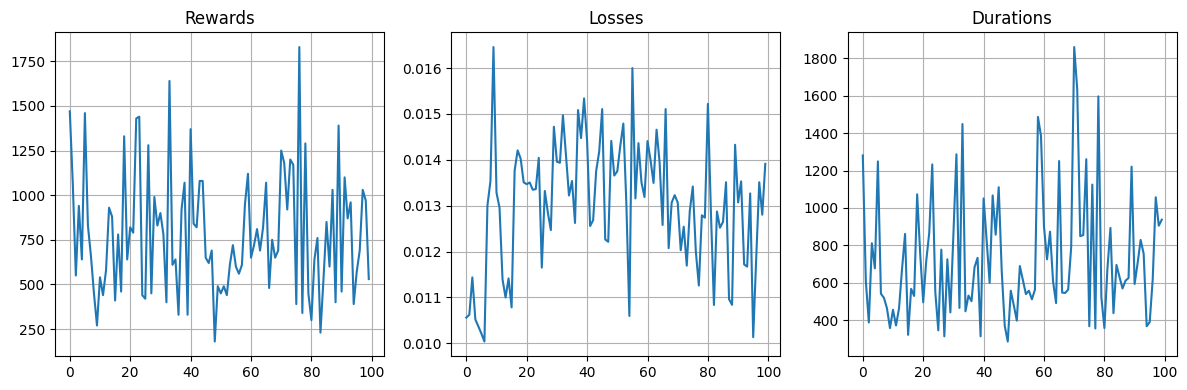

In [5]:
# Mostrar métricas resultantes (rewards, losses, durations)
rewards = results.get('rewards', [])
losses = results.get('losses', [])
durations = results.get('durations', [])

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(rewards)
plt.title('Rewards')
plt.grid(True)

plt.subplot(1,3,2)
plt.plot(losses)
plt.title('Losses')
plt.grid(True)

plt.subplot(1,3,3)
plt.plot(durations)
plt.title('Durations')
plt.grid(True)
plt.tight_layout()
plt.show()


=== Inspeccionando checkpoint ===
Keys en checkpoint: ['policy_net_state_dict', 'target_net_state_dict', 'optimizer_state_dict', 'epsilon']
✓ epsilon encontrado: 0.03178919665971424
Keys en checkpoint: ['policy_net_state_dict', 'target_net_state_dict', 'optimizer_state_dict', 'epsilon']
✓ epsilon encontrado: 0.03178919665971424


In [6]:
# --- Retrain chunk: resume training from an existing final model ---
import os
import torch
import numpy as np
import random
from collections import deque
import gymnasium as gym

from src.agent import DQNAgent
from src.utils import preprocess_frame, stack_frames


# Cell: Retrain con mejores parámetros
RESUME_MODEL = os.path.join(CHECKPOINT_DIR, f'final_model_estudiante.pth')
ADDITIONAL_EPISODES = 50
EARLY_STOP_PATIENCE_RESUME = 100
MA_WINDOW_RESUME = 10
MIN_DELTA_RESUME = 0.0
BUFFER_SAMPLE_SIZE = 10000
SAVE_EVERY_RESUME = 200
DEVICE_RESUME = DEVICE

# NUEVO: Reset epsilon para más exploración
RESET_EPSILON = 0.4  # Mayor exploración al continuar
LOAD_BUFFER = True  # Cargar experiencias previas

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

env = gym.make(ENV_NAME)
n_actions = env.action_space.n
state_shape = (4, 84, 84)

agent_resume = DQNAgent(state_shape, n_actions, device=DEVICE_RESUME)

if os.path.exists(RESUME_MODEL):
    print(f'📂 Cargando modelo desde {RESUME_MODEL}')
    buffer_loaded = agent_resume.load(RESUME_MODEL, load_buffer=LOAD_BUFFER)
    
    # Reset epsilon para más exploración
    agent_resume.epsilon = RESET_EPSILON
    print(f'🔄 Epsilon reseteado a: {agent_resume.epsilon}')
    
    if not buffer_loaded:
        print('⚠️ No se cargó buffer (iniciando con buffer vacío)')
else:
    print(f'❌ Modelo no encontrado: {RESUME_MODEL}')

# Try to inspect checkpoint metadata (safe attempt). If it fails, fallback to defaults.
start_episode = 0
start_steps = 0
best_ma = -np.inf
ck = None
if os.path.exists(RESUME_MODEL):
    try:
        # Try a safe weights-only inspection first; agent.load will handle permissive cases
        ck = torch.load(RESUME_MODEL, map_location='cpu', weights_only=True)
        start_episode = int(ck.get('episode', 0)) if isinstance(ck.get('episode', 0), (int, float)) else 0
        start_steps = int(ck.get('steps', 0)) if isinstance(ck.get('steps', 0), (int, float)) else 0
        best_ma = float(ck.get('best_ma', -np.inf)) if 'best_ma' in ck else best_ma
    except Exception as e:
        # fallback: inspect permissively only for trusted files
        try:
            ck = torch.load(RESUME_MODEL, map_location='cpu', weights_only=False)
            start_episode = int(ck.get('episode', 0)) if isinstance(ck.get('episode', 0), (int, float)) else 0
            start_steps = int(ck.get('steps', 0)) if isinstance(ck.get('steps', 0), (int, float)) else 0
            best_ma = float(ck.get('best_ma', -np.inf)) if 'best_ma' in ck else best_ma
        except Exception as e2:
            print('Warning: could not inspect checkpoint metadata safely:', e, e2)

    # Load weights into agent
    agent_resume.load(RESUME_MODEL)
    print(f'Loaded agent from {RESUME_MODEL} | start_episode={start_episode} | steps={start_steps} | best_ma={best_ma}')
    
    # INTENTAR cargar buffer si existe
    try:
        # Reload checkpoint to access buffer (using weights_only=False for buffer data)
        ck_full = torch.load(RESUME_MODEL, map_location='cpu', weights_only=False)
        
        if 'memory' in ck_full:
            old_buffer = list(ck_full['memory'])
            buffer_len = len(old_buffer)
            
            if buffer_len > 0:
                if buffer_len > BUFFER_SAMPLE_SIZE:
                    # Muestreo aleatorio uniforme
                    sampled = random.sample(old_buffer, BUFFER_SAMPLE_SIZE)
                    agent_resume.memory.buffer = deque(sampled, maxlen=agent_resume.memory.capacity)
                    agent_resume.memory.position = len(sampled)
                    print(f'✓ Buffer cargado con {len(sampled)} experiencias aleatorias (de {buffer_len} totales)')
                else:
                    # Si el buffer es pequeño, cargar todo
                    agent_resume.memory.buffer = ck_full['memory']
                    agent_resume.memory.position = len(agent_resume.memory.buffer)
                    print(f'✓ Buffer cargado completo con {buffer_len} experiencias')
            else:
                print('⚠ Buffer vacío en checkpoint. Iniciando con buffer vacío.')
        else:
            print('⚠ No se encontró buffer en el checkpoint. Iniciando con buffer vacío.')
    except Exception as e:
        print(f'⚠ No se pudo cargar buffer: {e}. Continuando con buffer vacío (esto es normal si es tu primer retrain).')
    
    # Resetear epsilon para más exploración
    agent_resume.epsilon = 0.3
    print(f'Epsilon reseteado a: {agent_resume.epsilon}')
else:
    print('Resume model not found:', RESUME_MODEL)

# Prepare state stacking
stacked = deque(maxlen=4)
update_target_frequency = 10000
steps = start_steps

# Training loop: run ADDITIONAL_EPISODES more episodes continuing counts
rewards = []
losses = []
durations = []

no_improve = 0
if best_ma == -np.inf:
    best_ma = -np.inf

episode_offset = start_episode

for ep in range(episode_offset + 1, episode_offset + 1 + ADDITIONAL_EPISODES):
    state, _ = env.reset()
    processed = preprocess_frame(state)
    state_stack = stack_frames(stacked, processed, True)

    done = False
    truncated = False
    ep_reward = 0.0
    ep_loss_sum = 0.0
    ep_loss_count = 0
    ep_steps = 0

    while not (done or truncated):
        action = agent_resume.select_action(state_stack, training=True)
        next_state, reward, done, truncated, _ = env.step(action)

        processed = preprocess_frame(next_state)
        next_stack = stack_frames(stacked, processed, False)

        clipped = np.clip(reward, -1, 1)
        agent_resume.memory.push(state_stack, action, clipped, next_stack, float(done))

        loss = agent_resume.train_step()
        if loss is not None:
            ep_loss_sum += loss
            ep_loss_count += 1

        ep_reward += reward
        ep_steps += 1
        steps += 1
        state_stack = next_stack

        if steps % update_target_frequency == 0:
            agent_resume.update_target_network()

    agent_resume.decay_epsilon()

    rewards.append(ep_reward)
    durations.append(ep_steps)
    avg_loss = (ep_loss_sum / ep_loss_count) if ep_loss_count else 0.0
    losses.append(avg_loss)

    # compute moving average over last MA_WINDOW_RESUME episodes
    if len(rewards) >= MA_WINDOW_RESUME:
        ma = np.mean(rewards[-MA_WINDOW_RESUME:])
    else:
        ma = np.mean(rewards) if rewards else -np.inf

    print(f'Resume Ep {ep} | Reward: {ep_reward:.2f} | Steps: {ep_steps} | Loss: {avg_loss:.4f} | Epsilon: {agent_resume.epsilon:.3f} | MA={ma:.3f}')

    if ep % SAVE_EVERY_RESUME == 0:
        email_prefix = EMAIL.split('@')[0]
        cp_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_ep{ep}_{email_prefix}.pth')
        agent_resume.save(cp_path)
        print(f'  -> Checkpoint saved: {cp_path}')

    # check improvement using MIN_DELTA_RESUME threshold
    if ma > best_ma + float(MIN_DELTA_RESUME):
        best_ma = ma
        no_improve = 0
        # overwrite canonical best model (saved in portable format by agent.save)
        email_prefix = EMAIL.split('@')[0]
        best_path = os.path.join(CHECKPOINT_DIR, f'best_model_{email_prefix}.pth')
        agent_resume.save(best_path)
        print(f'  -> New best MA({ma:.3f}). Model saved to {best_path}')
    else:
        no_improve += 1

    if no_improve >= EARLY_STOP_PATIENCE_RESUME:
        print(f'Stopping early after {no_improve} episodes without improvement (patience={EARLY_STOP_PATIENCE_RESUME}).')
        break

# Final save (overwrite canonical final model)
email_prefix = EMAIL.split('@')[0]
final_path = os.path.join(CHECKPOINT_DIR, f'final_model_{email_prefix}.pth')
agent_resume.save(final_path)
print('Retraining finished. Final model saved to', final_path)

env.close()

📂 Cargando modelo desde checkpoints\final_model_estudiante.pth
 Buffer cargado: 10000 experiencias (original: 72892)
🔄 Epsilon reseteado a: 0.4
Loaded agent from checkpoints\final_model_estudiante.pth | start_episode=0 | steps=0 | best_ma=-inf
⚠ No se pudo cargar buffer: name 'BUFFER_SAMPLE_SIZE' is not defined. Continuando con buffer vacío (esto es normal si es tu primer retrain).
Epsilon reseteado a: 0.3
Resume Ep 1 | Reward: 450.00 | Steps: 417 | Loss: 0.0121 | Epsilon: 0.298 | MA=450.000
  -> New best MA(450.000). Model saved to checkpoints\best_model_estudiante.pth
Resume Ep 2 | Reward: 500.00 | Steps: 565 | Loss: 0.0105 | Epsilon: 0.297 | MA=475.000
  -> New best MA(475.000). Model saved to checkpoints\best_model_estudiante.pth
Resume Ep 3 | Reward: 990.00 | Steps: 1123 | Loss: 0.0114 | Epsilon: 0.296 | MA=646.667
  -> New best MA(646.667). Model saved to checkpoints\best_model_estudiante.pth
Resume Ep 4 | Reward: 520.00 | Steps: 567 | Loss: 0.0120 | Epsilon: 0.294 | MA=615.000
R

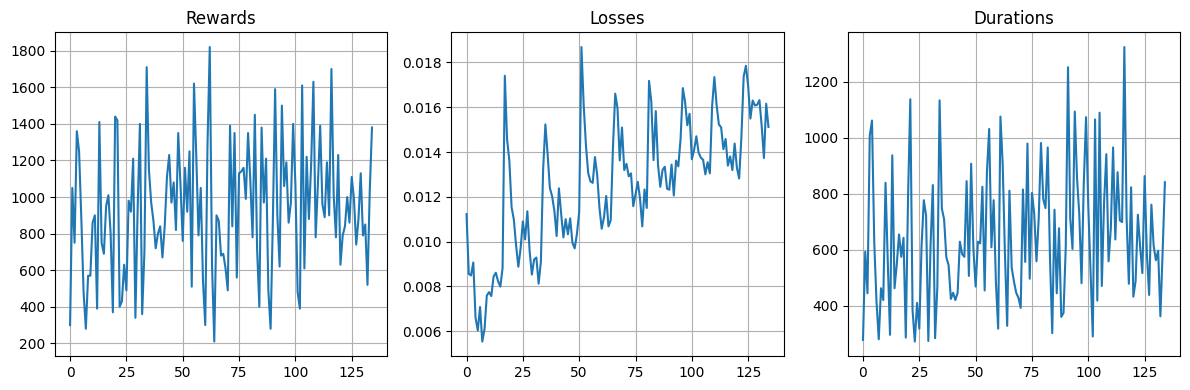

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(rewards)
plt.title('Rewards')
plt.grid(True)

plt.subplot(1,3,2)
plt.plot(losses)
plt.title('Losses')
plt.grid(True)

plt.subplot(1,3,3)
plt.plot(durations)
plt.title('Durations')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Grabar episodio con el mejor modelo
email_prefix = EMAIL.split('@')[0]
best_model_path = os.path.join(CHECKPOINT_DIR, f'final_model_estudiante.pth')
video_path = None

if os.path.exists(best_model_path):
    print(f'Cargando mejor modelo desde: {best_model_path}')
    state_shape = (4, 84, 84)
    n_actions = 6

    agent_test = DQNAgent(state_shape, n_actions)
    agent_test.load(best_model_path)

    video_path = record_episode(agent_test, email=EMAIL, output_dir='videos', env_name=ENV_NAME)
else:
    print('No se encontró best_model. Usando agente en memoria.')

print(f'\nVideo guardado en: {video_path}')


Cargando mejor modelo desde: checkpoints\final_model_estudiante.pth
Video saved: videos\estudiante_20251113205114_330.mp4
Score: 330 | Frames: 249

Video guardado en: videos\estudiante_20251113205114_330.mp4
Video saved: videos\estudiante_20251113205114_330.mp4
Score: 330 | Frames: 249

Video guardado en: videos\estudiante_20251113205114_330.mp4
